# Exploring 4 dimension reduction techniques on 2 sklearn toy datasets.

![dim_red_img](https://i.pinimg.com/originals/77/fa/32/77fa324afc57531dd8898a3ab7e83b87.jpg)

In this notebook we explore dimension reduction, specifically 2 linear techniques: Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA), as well as 2 manifold learning techniques: t-distributed Stochastic Neighbor Embedding (t-SNE) and Uniform Manifold Approximation and Projection (UMAP). The wine and digits datasets from `sklearn.datasets` are used for 2D and 3D projection respectively.

## Why reduce?

A large dataset with many features may contain less useful/unimportant features, this inherently increases the risk of overfitting.

High dimensional data also requires more storage space and is naturally difficult for humans to visualize - a projection into 2 or 3D space is what we can interpret easily.

Fewer features reduces the overall computation required to train the model.

Finally, less misleading data means better models in the real world.

## 2D projection of wine dataset

The wine dataset contains 178 samples belonging to 3 classes (labelled 0, 1 and 2) with 13 features. Load the data into a pandas Dataframe.

In [0]:
import time
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib.colors import to_hex

from sklearn.datasets import load_digits, load_wine
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import umap

In [0]:
wine = load_wine()
x_train = wine.data
y_train = wine.target

In [0]:
x_train = StandardScaler().fit_transform(x_train) # Normalize

In [0]:
features = ["Alcohol","Malic acid", "Ash", "Alcalinity of Ash", "Magnesium",
                        "Total phenols", "Flavanoids", "Nonflavanoid phenols",
                        "Proanthocyanins", "Color intensity", "Hue",
                        "OD280/OD315 of diluted wines", "Proline"]

In [0]:
df = pd.DataFrame(x_train, columns = features)
df['Target'] = y_train

In [7]:
df.head()

,Alcohol,Malic acid,Ash,Alcalinity of Ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Target
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009,0
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242,0
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148,0
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574,0
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874,0


Since we are going to reduce the dimensions of the data, we define `build_reduced_df` to accept the reduced components and rebuild our dataframe with them.

In [0]:
def build_reduced_df(data, columns, targets):
  
  # data = components from reduction technique
  # columns = name of columns in new dataframe
  # targets = original targets

  red_df = pd.DataFrame(data = data, columns = columns)
  red_df = pd.concat([red_df, targets], axis = 1)

  return red_df

`plot_projection` accepts a dataframe and plots the components in either 2D or 3D depending on the number of components passed. 

In [0]:
def plot_projection (dataframe, components, targets, title):

  # dataframe = dataframe containing reduced components
  # components = list of column names passed to dataframe
  # targets = list of target classes 
  # title = title of plot

  fig = plt.figure(figsize = (8,8))

  # Set colors to tabular10, converts this to a list of corresponding hex values
  cmap = plt.get_cmap('tab10')
  colors = [to_hex(cmap(i)) for i in np.linspace(0, 1, len(targets))]

  if len(components) == 2:  

    # 2D plot

    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel(components[0])
    ax.set_ylabel(components[1])
    ax.set_title(title)

    targets = targets

    for target, color in zip(targets,colors):
        indicesToKeep = dataframe['Target'] == target
        ax.scatter(dataframe.loc[indicesToKeep, components[0]],
                   dataframe.loc[indicesToKeep, components[1]],
                   c = color, s = 50)

  else:   

    # 3D plot

    ax = Axes3D(fig)
    ax.set_xlabel(components[0])
    ax.set_ylabel(components[1])
    ax.set_zlabel(components[2])
    ax.set_title(title)

    targets = targets

    for target, color in zip(targets,colors):
        indicesToKeep = dataframe['Target'] == target
        ax.scatter(dataframe.loc[indicesToKeep, components[0]],
                    dataframe.loc[indicesToKeep, components[1]],
                    dataframe.loc[indicesToKeep, components[2]],
                    c = color, s = 50)
        
  ax.legend(targets)
  ax.grid()

  plt.show()

### Reduction via PCA

In essence, PCA captures the points of the data with the highest variance and, using this, rotates and projects the data in the direction of increasing variance. This results in highly correlated features being merged together such that the new components are representative of the overall dataset. 

PCA is a unsupervised algorithm, hence only `x_train` is passed to the `fit_transform`. PCA has been found to [outperform](https://ieeexplore.ieee.org/document/908974) LDA in classification tasks where the number of samples for a class are relatively small.


In [0]:
N_COMPONENTS = 2 # Number of components

pca = PCA(n_components = N_COMPONENTS)
p_components = pca.fit_transform(x_train) # fit_transform since we normalized data

In [0]:
pca_df = build_reduced_df(p_components, ['PC 1', 'PC 2'], df['Target'])

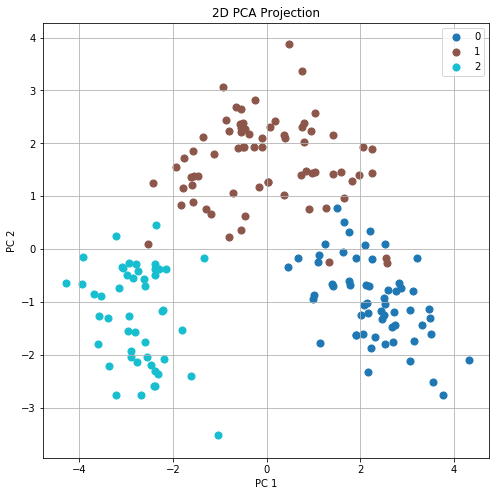

In [12]:
plot_projection(pca_df, ["PC 1", "PC 2"], [0, 1, 2], "2D PCA Projection")

### Reduction via LDA

LDA aims to maximize the class seperability in the embedded space. This is achieved by maximizing the between-class variance whilst minimizing the within-class variance.

Unlike PCA, LDA is a supervised algorithm, that is, it takes into account the class labels. 



In [0]:
N_COMPONENTS = 2

lda = LinearDiscriminantAnalysis(n_components = N_COMPONENTS) 
lda_components = lda.fit_transform(x_train, y_train)

In [0]:
lda_df = build_reduced_df(lda_components, ['LDA 1', 'LDA 2'], df['Target'])

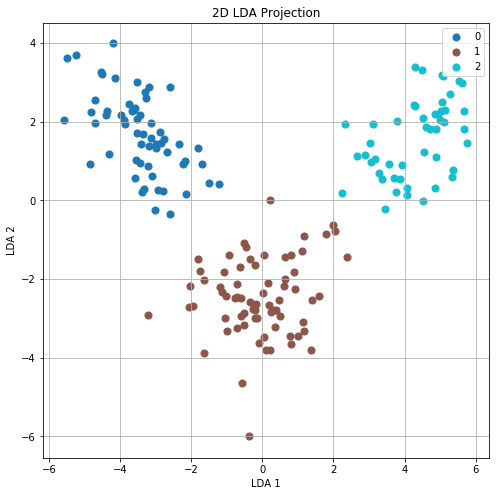

In [15]:
plot_projection(lda_df, ["LDA 1", "LDA 2"], [0, 1, 2], "2D LDA Projection")

## Manifold learning

When our data does not lie in a linear subspace, manifold learning methods (such as t-SNE and UMAP) are better suited. These techniques are based on the [Manifold Hypothesis](https://arxiv.org/abs/1310.0425) which states that the most relevant information in high dimensional data is often concentrated within a small number of lower dimensional manifolds.

Both algorithims below necessarily warp the high-dimensional shape when projecting into a lower dimension. This results in cluster sizes and distances between clusters in the embedding to be meaningless.

### Reduction via t-SNE

In essence, t-SNE computes the probability that pairs of datapoints within the high dimensional space are related and aims to produce a low dimensional embedding which produces a similar distribution. The use of stochastic neighbors allows t-SNE to consider both the local and global structure.

Note: t-SNE is non-convex, that is, we may get stuck in some local minima. In an attempt to avoid this 'early compression' (simply adding an L2 penalty to the cost function during early stages of optimization) is used.

Note: t-SNE is non-deterministic, sequential reruns on the same data may not produce the same outputs. 



In [0]:
# PERPLEXITY = number of nearest neighbors for each point
# Higher value => Inc. global structure preservation
#              => Inc. training time
PERPLEXITY = 30
N_COMPONENTS = 2

tsne = TSNE(n_components=N_COMPONENTS, verbose=0, perplexity=PERPLEXITY, 
            n_iter=300)
tsne_components = tsne.fit_transform(x_train)

In [0]:
tsne_df = build_reduced_df(tsne_components, ['tsne 1', 'tsne 2'], df['Target'])

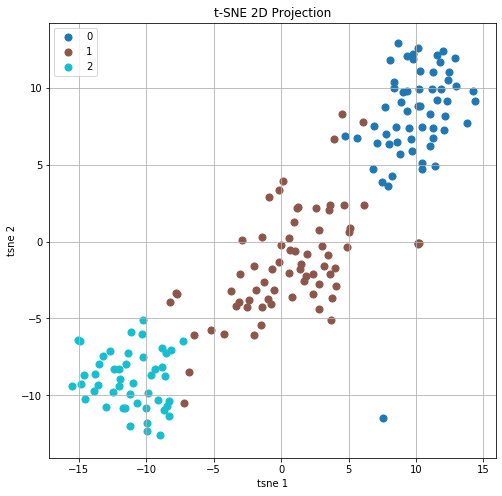

In [18]:
plot_projection(tsne_df, ["tsne 1", "tsne 2"], 
                [0,1,2], "t-SNE 2D Projection")

### Reduction via UMAP

UMAP is similar to t-SNE, however it is faster, scales better and strikes a better balance between the preservation of local vs global structure: UMAP is better at preserving the global structure in the final projection. This implies that the inter-cluster relations are *potentially* more meaningful than in t-SNE.

Note: UMAP is non-deterministic as well.

For a great visualization of the trade off between local and global structure preservation between t-SNE and UMAP, have a look at this [article](https://pair-code.github.io/understanding-umap/).


In [0]:
# N_NEIGHBORS = number of initial neighbors for each point
# Higher value => Inc. global structure preservation


# MIN_DST = minimum distance between points in projection
# Higher value => Inc. global structure preservation
#              => 'Looser' clusters


N_NEIGHBORS = 15
MIN_DIST = 0.1
N_COMPONENTS = 2

umap_reducer = umap.UMAP(n_neighbors = N_NEIGHBORS, min_dist = MIN_DIST,
                 n_components = N_COMPONENTS)
umap_reducer = umap_reducer.fit_transform(x_train)

In [0]:
umap_df = build_reduced_df(umap_reducer, ['umap 1', 'umap 2'], df["Target"])

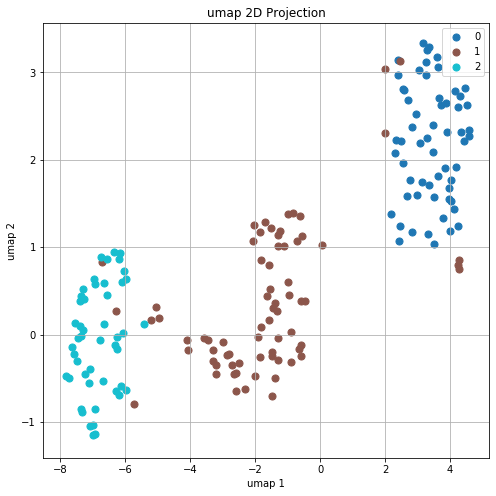

In [21]:
plot_projection(umap_df, ["umap 1", "umap 2"], 
                [0,1,2], "umap 2D Projection")

## 3D projection of digits dataset

The digits dataset contains 1797 samples belonging to 10 classes. Each digit is an 8x8 image, that is, there are 64 dimensions. 

In [0]:
mnist = load_digits()
x_train_mnist = mnist.data / 255.0
y_train_mnist = mnist.target

In [0]:
# Just for naming columns
feat_cols = [ 'pixel'+str(i) for i in range(x_train_mnist.shape[1])]

In [0]:
mnist_df = pd.DataFrame(x_train_mnist, columns = feat_cols)

In [0]:
mnist_df['Target'] = y_train_mnist

### PCA

In [26]:
N_COMPONENTS = 3

time_start = time.time()

pca_mnist = PCA(n_components = N_COMPONENTS)
p_mnist_components = pca_mnist.fit_transform(x_train_mnist)

print('PCA reduction complete! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA reduction complete! Time elapsed: 0.022530078887939453 seconds


In [0]:
pca_mnist_df = build_reduced_df(p_mnist_components, 
                                ['PC 1', 'PC 2', 'PC 3'], 
                                mnist_df['Target'])

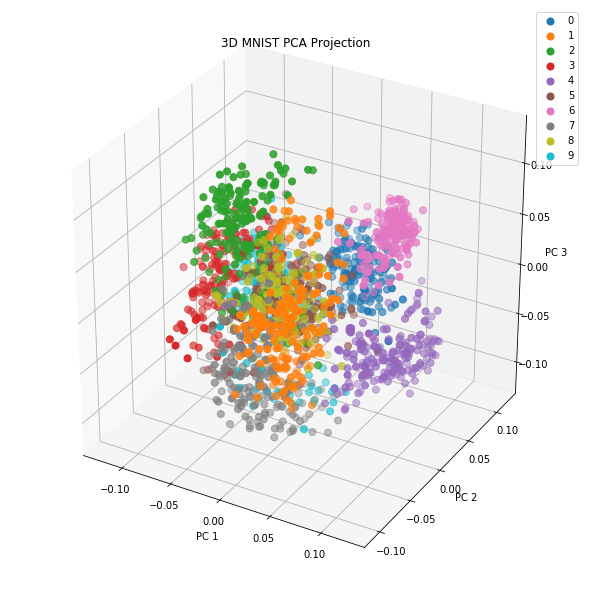

In [28]:
plot_projection(pca_mnist_df, 
                ['PC 1', 'PC 2', 'PC 3'], 
                [i for i in range(10)],   # classes  are digits 0-9
                "3D MNIST PCA Projection")

### LDA

In [29]:
N_COMPONENTS = 3

time_start = time.time()

lda = LinearDiscriminantAnalysis(n_components = N_COMPONENTS) 
lda_mnist_components = lda.fit_transform(x_train_mnist, y_train_mnist)

print('LDA reduction complete! Time elapsed: {} seconds'.format(time.time()-time_start))

LDA reduction complete! Time elapsed: 0.040162086486816406 seconds


In [0]:
lda_mnist_df = build_reduced_df(lda_mnist_components, 
                                ['LDA 1', 'LDA 2', 'LDA 3'], 
                                mnist_df['Target'])

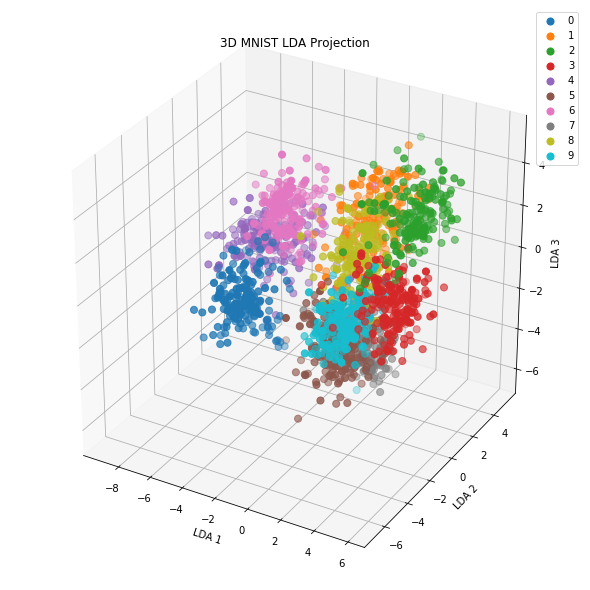

In [31]:
plot_projection(lda_mnist_df, 
                ['LDA 1', 'LDA 2', 'LDA 3'], 
                [i for i in range(10)],
                "3D MNIST LDA Projection")

### t-SNE

In [32]:
PERPLEXITY = 30
N_COMPONENTS = 3

time_start = time.time()

tsne_mnist = TSNE(n_components=N_COMPONENTS, verbose=0, 
                  perplexity=PERPLEXITY, n_iter=300)

tsne_mnist_components = tsne_mnist.fit_transform(x_train_mnist)

print('t-SNE reduction complete! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE reduction complete! Time elapsed: 13.73371148109436 seconds


In [0]:
tsne_mnist_df = build_reduced_df(tsne_mnist_components, 
                                 ['tsne 1', 'tsne 2', 'tsne 3'], 
                                 mnist_df['Target'])

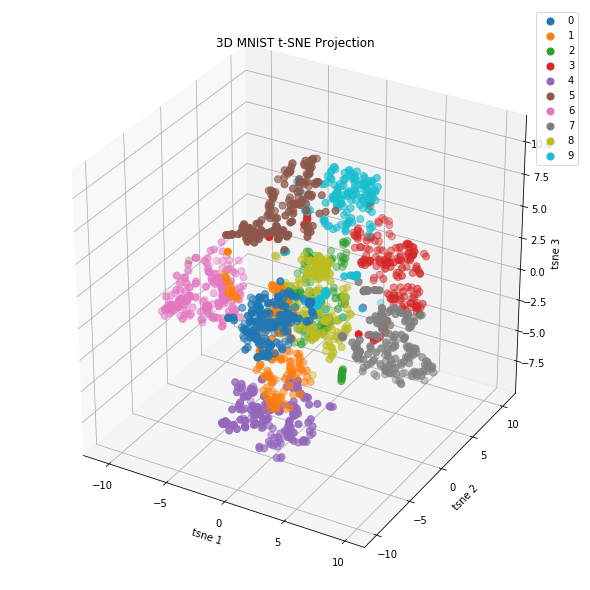

In [34]:
plot_projection(tsne_mnist_df, 
                ['tsne 1', 'tsne 2', 'tsne 3'], 
                [i for i in range(10)], 
                "3D MNIST t-SNE Projection")

### UMAP

In [35]:
N_NEIGHBORS = 15
MIN_DIST = 0.2
N_COMPONENTS = 3

time_start = time.time()

umap_mnist_reducer = umap.UMAP(n_neighbors = N_NEIGHBORS, min_dist = MIN_DIST,
                 n_components = N_COMPONENTS)

umap_mnist_components = umap_mnist_reducer.fit_transform(x_train_mnist)

print('UMAP reduction complete! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP reduction complete! Time elapsed: 4.89805793762207 seconds


In [0]:
umap_mnist_df = build_reduced_df(umap_mnist_components, 
                                 ['umap 1', 'umap 2', 'umap 3'], 
                                 mnist_df['Target'])

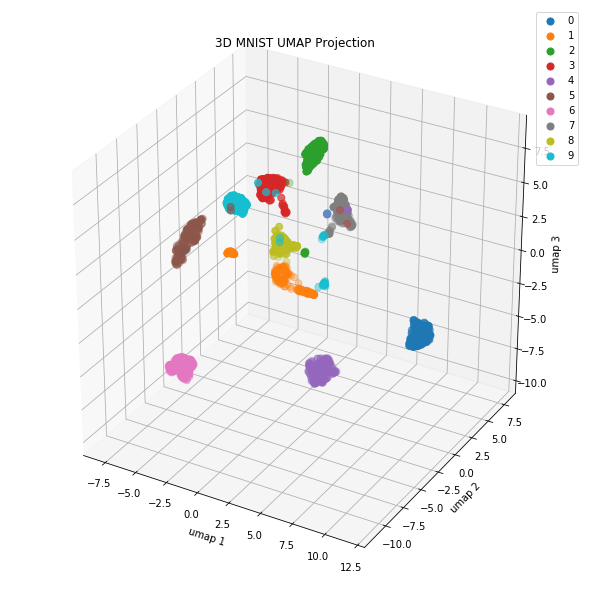

In [37]:
plot_projection(umap_mnist_df, 
                ['umap 1', 'umap 2', 'umap 3'], 
                [i for i in range(10)], 
                "3D MNIST UMAP Projection")

## Conclusion

From the time elapses above we can see PCA and LDA are very quick compared to t-SNE and UMAP, however we can see PCA does not cluster the data as well. LDA clusters the data better than PCA (since it prioritizes class seperability), and exhibits the most distinct separability amongst the 2D projections. However, it does not form the distinct clusters seen by t-SNE and particularly UMAP in the 3D projections.

t-SNE is significantly [slower](https://umap-learn.readthedocs.io/en/latest/benchmarking.html) than UMAP. In fact, for really large feature spaces, one should use another reduction technique (such as PCA) *prior* to using t-SNE. Further, UMAP produces distinctly tighter and more seperated clusters compared to t-SNE in the 3D projections.

